Överskådlig sammanfattning av AdventureWorks.

AdventureWorks2022 är en fiktiv databas framtagen av Microsoft i utbildningssyfte. Företaget ska föreställa ett multinationellt detaljhandelsföretag baserat i USA. Databasen är organiserad i en Online Transaction Processing-struktur (OLTP) 
Relationsbaserad (inte dokumentbaserad)

Databasen omfattar tidsperioden från och med juni 2011 till och med juni 2014. 


In [6]:
import sqlalchemy as sa
from sqlalchemy.engine import URL
from sqlalchemy import create_engine, inspect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
SERVER = 'localhost'
DATABASE = 'AdventureWorks2022'
 
connection_string = f'DRIVER={{ODBC Driver 18 for SQL Server}};SERVER={SERVER};DATABASE={DATABASE};Trusted_Connection=yes;Encrypt=no'
 
connection_url = URL.create('mssql+pyodbc', query={'odbc_connect': connection_string})
 
engine = create_engine(connection_url)

In [9]:
connection = engine.connect()

Inledning till del två, dvs analysdelen.
Jag har tittat närmare på datan över kasserat material från produktionen i AdventureWorks. 

In [27]:
scrapOverviewQuery = """
SELECT
	W.ScrapReasonID
	,SUM(W.ScrappedQty) AS TotalScrappedQty
	,S.Name AS ScrapReason
FROM Production.WorkOrder AS W
INNER JOIN Production.ScrapReason AS S
ON W.ScrapReasonID = S.ScrapReasonID
WHERE W.ScrappedQty > 0
GROUP BY W.ScrapReasonID, S.Name
ORDER BY ScrapReasonID;
"""
scrapOverview = pd.read_sql(scrapOverviewQuery, engine)
print(scrapOverview)

    ScrapReasonID  TotalScrappedQty                      ScrapReason
0               1               459    Brake assembly not as ordered
1               2               491                  Color incorrect
2               3               575                   Gouge in metal
3               4               762          Drill pattern incorrect
4               5               506             Drill size too large
5               6               826             Drill size too small
6               7               202                  Handling damage
7               8              1271             Paint process failed
8               9               743            Primer process failed
9              10               692     Seat assembly not as ordered
10             11               306               Stress test failed
11             12               394  Thermoform temperature too high
12             13               876   Thermoform temperature too low
13             14               98

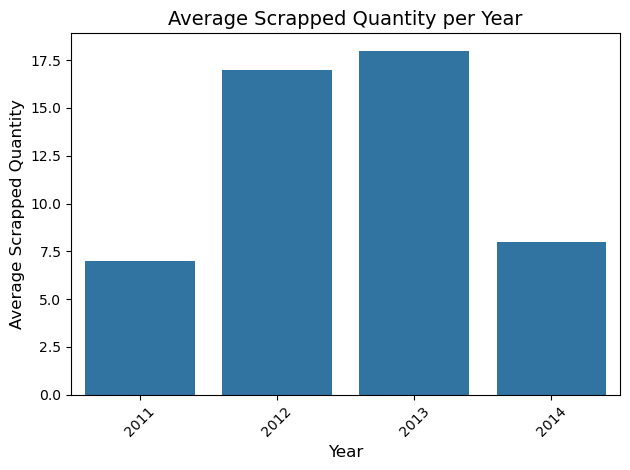

In [13]:
# Kasserat material i medeltal fördelat per år (2011-2014)

scrap_mean_yearly_query = """
SELECT YEAR(EndDate) AS ScrapYear, AVG(ScrappedQty) AS AvgScrap
FROM Production.WorkOrder
WHERE ScrappedQty > 0
GROUP BY YEAR(EndDate);
"""

yearlyScrapMean = pd.read_sql(scrap_mean_yearly_query, engine)

# Barplot
sns.barplot(data=yearlyScrapMean, x='ScrapYear', y='AvgScrap')
plt.title("Average Scrapped Quantity per Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Scrapped Quantity", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

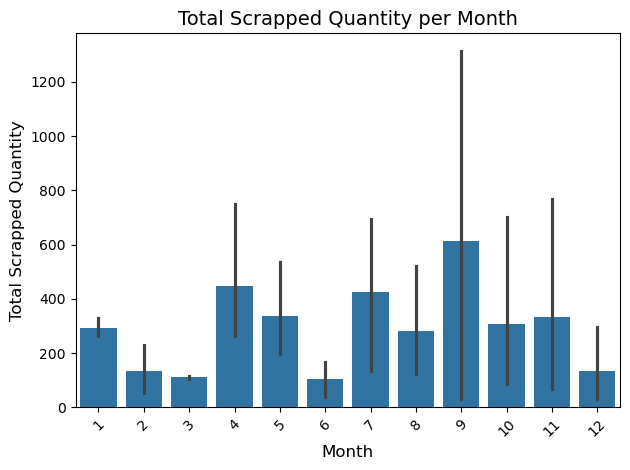

In [14]:
# Kasserat material, total mängd per månad (2011-06 till 2014-06)

scrapMonthlyQuery= """
SELECT YEAR(EndDate) AS ScrapYear
	,MONTH(EndDate) AS ScrapMonth
	,SUM(ScrappedQty) AS TotalScrapQty
FROM Production.WorkOrder
WHERE ScrappedQty > 0
GROUP BY YEAR(EndDate), MONTH(EndDate)
ORDER BY ScrapYear, ScrapMonth;
"""
scrapMonthlyTotal= pd.read_sql(scrapMonthlyQuery, engine)

# Barplot
sns.barplot(data=scrapMonthlyTotal, x='ScrapMonth', y='TotalScrapQty')
plt.title("Total Scrapped Quantity per Month", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Scrapped Quantity", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

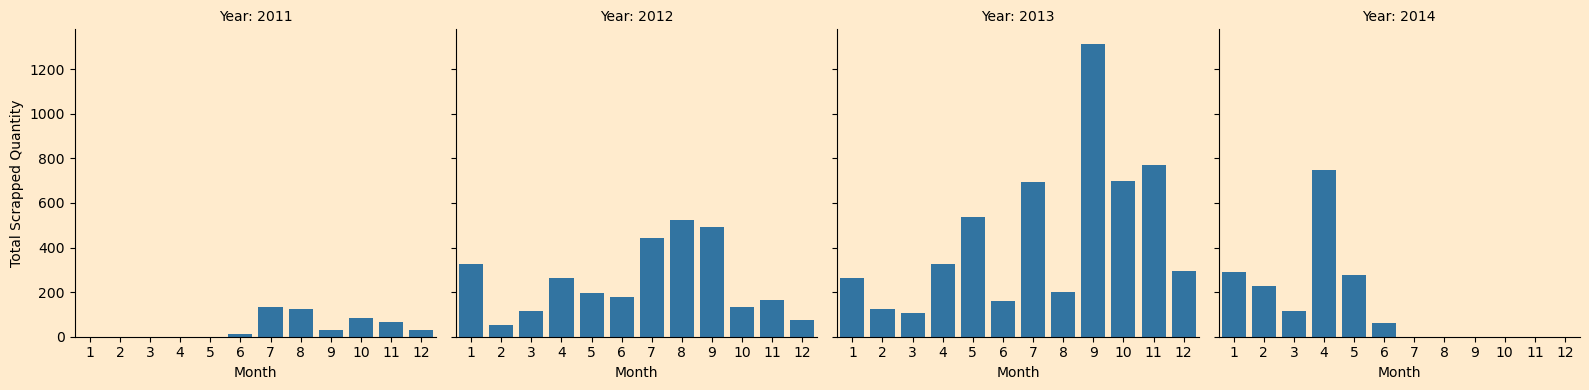

In [75]:
scrap_monthly_query = """
SELECT YEAR(EndDate) AS ScrapYear,
       MONTH(EndDate) AS ScrapMonth,
       SUM(ScrappedQty) AS TotalScrap
FROM Production.WorkOrder
WHERE ScrappedQty > 0
GROUP BY YEAR(EndDate), MONTH(EndDate)
ORDER BY ScrapYear, ScrapMonth;
"""

scrap_data = pd.read_sql(scrap_monthly_query, engine)
scrap_data['YearMonth'] = scrap_data['ScrapYear'].astype(str) + '-' + scrap_data['ScrapMonth'].astype(str).str.zfill(2)

month_order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

g = sns.FacetGrid(scrap_data, col="ScrapYear", col_wrap=4, height=4)
g.map(sns.barplot, "ScrapMonth", "TotalScrap", order=month_order)
g.set_axis_labels("Month", "Total Scrapped Quantity")
g.set_titles("Year: {col_name}")
plt.gcf().set_facecolor('blanchedalmond')
for ax in g.axes.flat:
    ax.set_facecolor('blanchedalmond')
g.tight_layout()

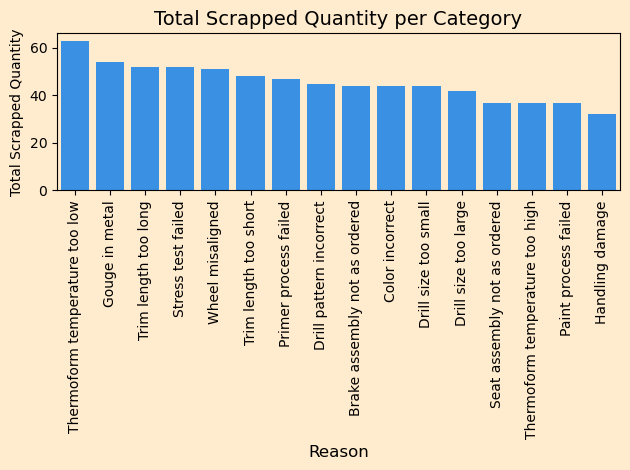

In [72]:
# Totalt antal kasserad volym per kasseringskategori
scrapReasonCategoriesQuery = """
SELECT
	W.ScrapReasonID
	,S.Name AS ScrapReason
	,COUNT(*) AS ScrapCount
FROM Production.WorkOrder AS W
INNER JOIN Production.ScrapReason AS S
ON W.ScrapReasonID = S.ScrapReasonID
WHERE W.ScrapReasonID IS NOT NULL
GROUP BY W.ScrapReasonID, S.Name
ORDER BY ScrapCount DESC;
"""

scrapReasonCategoryTotal= pd.read_sql(scrapReasonCategoriesQuery, engine)

# Barplot
sns.barplot(data=scrapReasonCategoryTotal, x='ScrapReason', y='ScrapCount', color='dodgerblue')
plt.title("Total Scrapped Quantity per Category", fontsize=14)
plt.xlabel("Reason", fontsize=12)
plt.ylabel("Total Scrapped Quantity", fontsize=10)
plt.xticks(rotation=90)
plt.gcf().set_facecolor('blanchedalmond')
ax = plt.gca()
ax.set_facecolor('blanchedalmond')
plt.tight_layout()

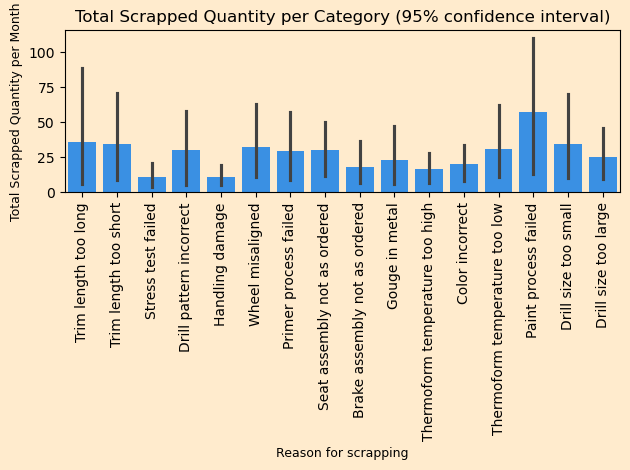

In [79]:
# Kasseringsvolym per kategori, jämfört månadsvis
scrapReasonsMonthlyQuery = """
SELECT 
    YEAR(W.StartDate) AS ScrapYear,
    MONTH(W.StartDate) AS ScrapMonth,
    W.ScrapReasonID,
    S.Name AS ScrapReason,
    SUM(W.ScrappedQty) AS TotalScrappedQty
FROM 
    Production.WorkOrder AS W
INNER JOIN 
    Production.ScrapReason AS S
ON 
    W.ScrapReasonID = S.ScrapReasonID
WHERE 
    W.ScrapReasonID IS NOT NULL
    AND W.ScrappedQty > 0
GROUP BY 
    YEAR(W.StartDate), 
    MONTH(W.StartDate), 
    W.ScrapReasonID, 
    S.Name
ORDER BY 
    ScrapYear, ScrapMonth, TotalScrappedQty DESC;
"""

scrapReasonsMonthly = pd.read_sql(scrapReasonsMonthlyQuery, engine)

sns.barplot(data=scrapReasonsMonthly, x='ScrapReason', y='TotalScrappedQty', color='DodgerBlue')
plt.title("Kasserad volym, medelvärde per månad (95% konfidensintervall)", fontsize=12)
plt.xlabel("Anledning till kassering", fontsize=9)
plt.ylabel("Kasserad volym per månad", fontsize=9)
plt.xticks(rotation=90)
plt.gcf().set_facecolor('blanchedalmond')
ax = plt.gca()
ax.set_facecolor('blanchedalmond')
plt.tight_layout()